In [1]:
import os
import zipfile

import shutil

In [6]:
import os
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

class DataGenerator(Sequence):

    def __init__(self, df, X, y1, y2, batch_size, img_size, directory, shuffle=False):
        self.df = df.copy()
        self.X = X
        self.y1 = y1
        self.y2 = y2
        self.directory = directory
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.n = len(self.df)
        print(f"Number of records: {self.n}")
        print(f"Number of steps: {-(self.n // -self.batch_size)}")

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return -(self.n // -self.batch_size)

    def __getitem__(self,index):

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X, y1, y2 = self.__get_data(batch)
        return X, (y1,y2)

    def __get_data(self,batch):

        X,y1,y2 = [],[],[]
        for i, record in batch.iterrows():
            img = load_img(os.path.join(self.directory,record[self.X]),target_size=(self.img_size,self.img_size))
            img = img_to_array(img)
            img = img/255.
            X.append(img)
            coods = record[self.y1].values
            y1.append(coods)
            y2.append(record[self.y2])

        return np.array(X,dtype=np.float32),np.array(y1,dtype=np.float32),np.array(y2,dtype=np.float32)

In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
# from bboxregressiongenerator import DataGenerator
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import cv2

In [2]:
import gdown
url = 'https://drive.google.com/uc?export=download&id=12maA3gCAw12CyFXn9BExNO9ANKYFRLRG'
output = 'dataset.zip'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=12maA3gCAw12CyFXn9BExNO9ANKYFRLRG
From (redirected): https://drive.google.com/uc?export=download&id=12maA3gCAw12CyFXn9BExNO9ANKYFRLRG&confirm=t&uuid=9813e42a-4d6e-4208-82eb-5092d89b9a1d
To: /content/dataset.zip
100%|██████████| 37.7M/37.7M [00:00<00:00, 121MB/s]


'dataset.zip'

In [3]:
# Ekstrak dataset
local_zip = '/content/dataset.zip'
with zipfile.ZipFile(local_zip, 'r') as zip_ref:
    zip_ref.extractall('/content/file')

data_path = '/content/file'
# Periksa direktori yang diekstrak
print(os.listdir(data_path))

['annotations', 'train']


In [8]:
directory = '/content/file/annotations'
annotations = os.listdir(directory)

In [9]:
with open(os.path.join(directory,'/content/file/annotations/1000_jpg.rf.bcd863307394a34af1e65812afec9ced.xml'), 'r') as f:
  file = f.read()
data = BeautifulSoup(file, "xml")

objects = data.find_all('object')
length = len(objects)
filename = data.find("filename").text
img_width = int(data.find('size').width.text)
img_height = int(data.find('size').height.text)

In [10]:
xmin = int(objects[0].bndbox.xmin.text)
ymin = int(objects[0].bndbox.ymin.text)
xmax = int(objects[0].bndbox.xmax.text)
ymax = int(objects[0].bndbox.ymax.text)

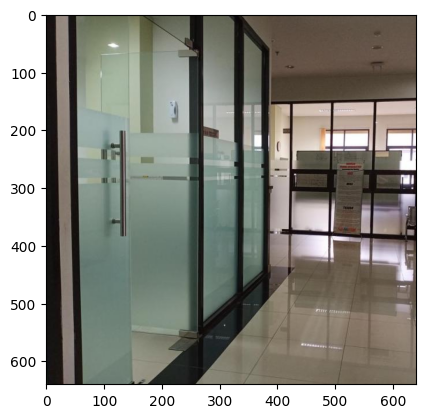

In [11]:
img = cv2.imread("/content/file/train/1000_jpg.rf.bcd863307394a34af1e65812afec9ced.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

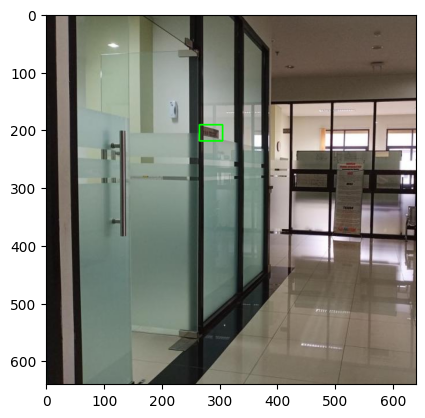

In [12]:
img = cv2.rectangle(img, (xmin,ymin), (xmax,ymax), (0,255,0), 2)
plt.imshow(img)

In [13]:
img.shape

(640, 640, 3)

In [14]:
h,w = img.shape[:2]

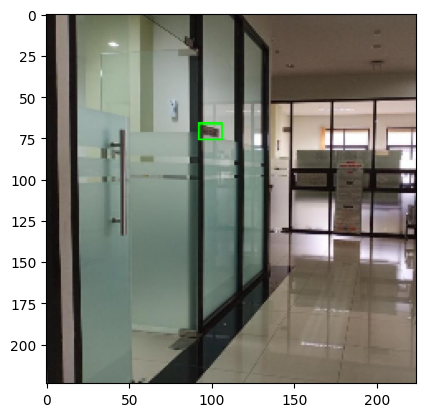

In [15]:
xmin /= w
xmax /= w
ymin /= h
ymax /= h

img_r = cv2.resize(img, (224,224))

xmin = int(xmin*224)
xmax = int(xmax*224)
ymin = int(ymin*224)
ymax = int(ymax*224)

img_r = cv2.rectangle(img_r, (xmin,ymin), (xmax,ymax), (0,255,0), 1)
plt.imshow(img_r)

In [16]:
records = []
for annot_file in annotations:

    with open(os.path.join(directory,annot_file), 'r') as f:
        file = f.read()
    data = BeautifulSoup(file, "xml")

    objects = data.find_all('object')
    length = len(objects)
    filename = data.find("filename").text
    img_width = int(data.find('size').width.text)
    img_height = int(data.find('size').height.text)

    for i in range(length):
        class_name = data.find_all('object')[i].find('name').text
        xmin = int(data.find_all('object')[i].find('bndbox').find('xmin').text)/img_width
        ymin = int(data.find_all('object')[i].find('bndbox').find('ymin').text)/img_height
        xmax = int(data.find_all('object')[i].find('bndbox').find('xmax').text)/img_width
        ymax = int(data.find_all('object')[i].find('bndbox').find('ymax').text)/img_height

        records.append([filename,class_name,xmin,ymin,xmax,ymax])

In [17]:
df = pd.DataFrame(records,columns=['filename','class','xmin','ymin','xmax','ymax'])
df.drop_duplicates(subset=['filename'],inplace=True)
df['class'] = df['class'].apply(lambda x: 1.0 if x=='dog' else 0.0)
df

,filename,class,xmin,ymin,xmax,ymax
0,895_jpg.rf.5704304a17ed641c253ca263d0ef3204.jpg,0.0,0.864062,0.264062,1.001562,0.325000
1,645_jpg.rf.6bba1ca25ae1f7d1a914cd1867912d7b.jpg,0.0,0.779687,0.365625,0.792188,0.389062
2,711_jpg.rf.d8fa014165dad2d59c76d589b3fe61fd.jpg,0.0,0.214062,0.298438,0.403125,0.393750
3,617_jpg.rf.f7ee31f54e3c115f9270e59dd87d1ff8.jpg,0.0,0.306250,0.075000,0.707812,0.296875
4,1051_jpg.rf.d361955f275a8391b3074f8e8bc29ba9.jpg,0.0,0.335938,0.398438,0.406250,0.448437
...,...,...,...,...,...,...
1220,954_jpg.rf.707d73fe17e66136168e65c7d9708392.jpg,0.0,0.660937,0.179688,0.790625,0.225000
1221,29_jpg.rf.b7adb93bae3cdfdf953425e759ec1233.jpg,0.0,0.331250,0.468750,0.476562,0.542188
1222,353_jpg.rf.7633a6f7deb313cef231a6a210e97fdd.jpg,0.0,0.337500,0.337500,0.698438,0.492188
1223,558_jpg.rf.be63d62be796bb4b3ccec23f34e95afc.jpg,0.0,0.442188,0.400000,0.535937,0.425000


In [18]:
df['class'].value_counts()

,count
class,
0.0,1225


In [19]:
image_directory = '/content/file/train'

In [20]:
df = df.sample(frac=1).reset_index(drop=True)
train = df.head(3000)
test = df.tail(686).reset_index(drop=True)

In [21]:
train_gen = DataGenerator(train,'filename',['xmin','ymin','xmax','ymax'],'class',32,256,image_directory)
test_gen = DataGenerator(test,'filename',['xmin','ymin','xmax','ymax'],'class',32,256,image_directory)

Number of records: 1225
Number of steps: 39
Number of records: 686
Number of steps: 22


In [22]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model, Sequential

In [23]:
img_size = 256
base_model = InceptionV3(include_top = False,
                       weights = 'imagenet',
                       input_shape = (img_size,img_size,3))

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [24]:
for layer in base_model.layers:
    if 'mixed7' in layer.name:
        break
    layer.trainable = False

In [38]:
last_output = base_model.output
x = GlobalAveragePooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output1 = Dense(4, activation='sigmoid', name='bbox_reg')(x)
output2 = Dense(1, activation='sigmoid', name='classifier')(x)
model = Model(inputs=base_model.inputs, outputs=[output1,output2])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
             loss=['mse','binary_crossentropy'],
             loss_weights=[0.6,0.4],
             metrics=[['mae'],['accuracy']]) # Changed metrics to a nested list with metrics for each output

In [39]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [40]:
model_name = "model.keras"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)
earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

In [41]:
try:
    history = model.fit(train_gen,
                        epochs=25,
                        validation_data=test_gen,
                        callbacks=[checkpoint,earlystopping])
except KeyboardInterrupt:
    print("\nTraining Stopped")

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 618ms/step - bbox_reg_mae: 0.1958 - classifier_accuracy: 0.9374 - loss: 0.0983

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 0.01821, saving model to model.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - bbox_reg_mae: 0.1953 - classifier_accuracy: 0.9385 - loss: 0.0971 - val_bbox_reg_mae: 0.1374 - val_classifier_accuracy: 1.0000 - val_loss: 0.0182
Epoch 2/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - bbox_reg_mae: 0.1278 - classifier_accuracy: 1.0000 - loss: 0.0171
Epoch 2: val_loss improved from 0.01821 to 0.01039, saving model to model.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 25s 261ms/step - bbox_reg_mae: 0.1277 - classifier_accuracy: 1.0000 - loss: 0.0170 - val_bbox_reg_mae: 0.0994 - val_classifier_accuracy: 1.0000 - val_loss: 0.0104
Epoch 3/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - bbox_reg_mae: 0.1025 - classifier_accuracy: 1.0000 - loss: 0.0112
Epoch 3: val_loss improved from 0.01039 to 0.00631, saving model to model.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 270ms/step - bbox_reg_mae: 0.1025 - classifier_accuracy: 1.0000 - loss: 0.0112 - val_bbox_reg_mae: 0.0777 - val_cla

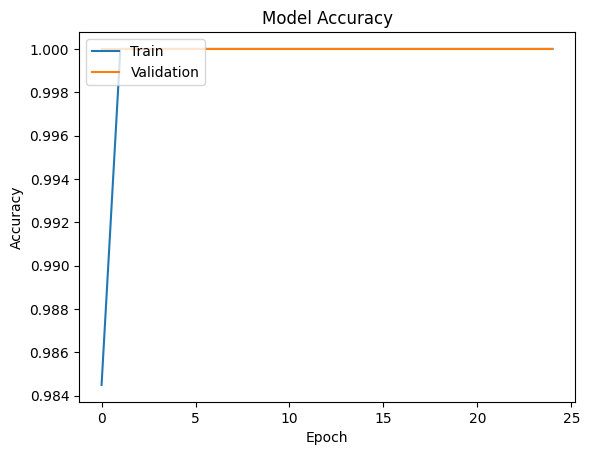

In [59]:
import matplotlib.pyplot as plt
plt.plot(history.history['classifier_accuracy'])
plt.plot(history.history['val_classifier_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


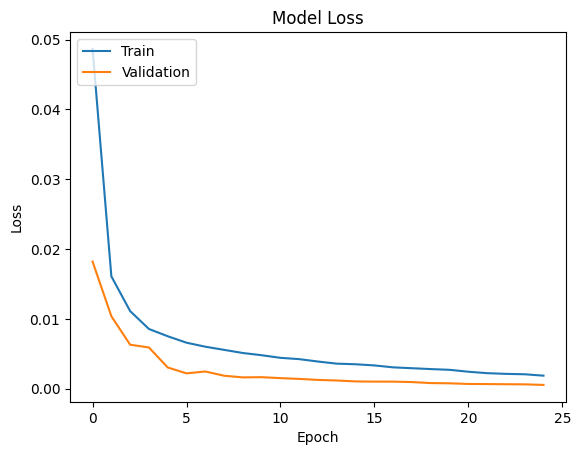

In [60]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


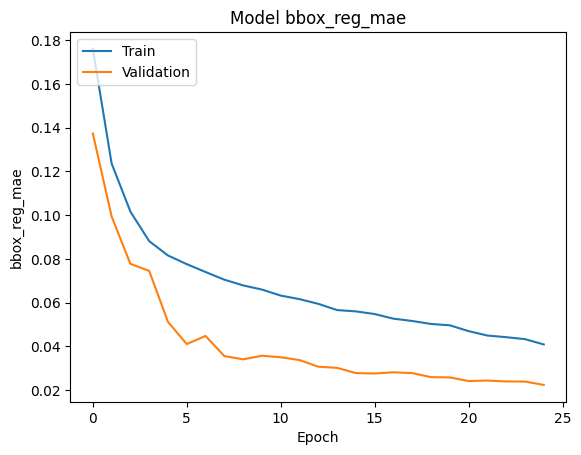

In [61]:
import matplotlib.pyplot as plt
plt.plot(history.history['bbox_reg_mae'])
plt.plot(history.history['val_bbox_reg_mae'])
plt.title('Model bbox_reg_mae')
plt.ylabel('bbox_reg_mae')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [42]:
outputs = model.predict(test_gen)

22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 437ms/step


In [43]:
y_bbox,y_pred = outputs
y_pred[y_pred>0.5] = 1
y_pred[y_pred<0.5] = 0
y_pred = y_pred.reshape(-1,)

In [44]:
test

,filename,class,xmin,ymin,xmax,ymax
0,780_jpg.rf.b0fad7725a83172c2a24dd22b9ea5483.jpg,0.0,0.895312,0.226562,0.928125,0.275000
1,636_jpg.rf.cf9bc09ef69edb0767b9ea8bcdafb449.jpg,0.0,0.160938,0.226562,0.542188,0.346875
2,1058_jpg.rf.d3e68b392632c5f9447801e9acafee64.jpg,0.0,0.715625,0.276562,0.825000,0.325000
3,233_jpg.rf.3e60763ad90e34be5a6546517e224e27.jpg,0.0,0.450000,0.471875,0.606250,0.550000
4,433_jpg.rf.ab84154fe19502b7071fc7a6d141b382.jpg,0.0,0.325000,0.410938,0.590625,0.542188
...,...,...,...,...,...,...
681,755_jpg.rf.3405c43548b68bc1ca4abfee18e0a472.jpg,0.0,0.401562,0.207813,0.715625,0.364063
682,469_jpg.rf.1f9e04da5a1356bc9201de1ed046d14b.jpg,0.0,0.434375,0.284375,0.885938,0.406250
683,707_jpg.rf.cab05182759e3acd617d6a5289c23772.jpg,0.0,0.485938,0.276562,0.517188,0.328125
684,1129_jpg.rf.0936d1dfc386948a637a262c7e9ef435.jpg,0.0,0.356250,0.307812,0.796875,0.471875


In [45]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [46]:
filenames = test['filename'].sample(25).tolist()

<ipython-input-57-6047b735cb3f>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = labels[int(y_pred[x.index])]


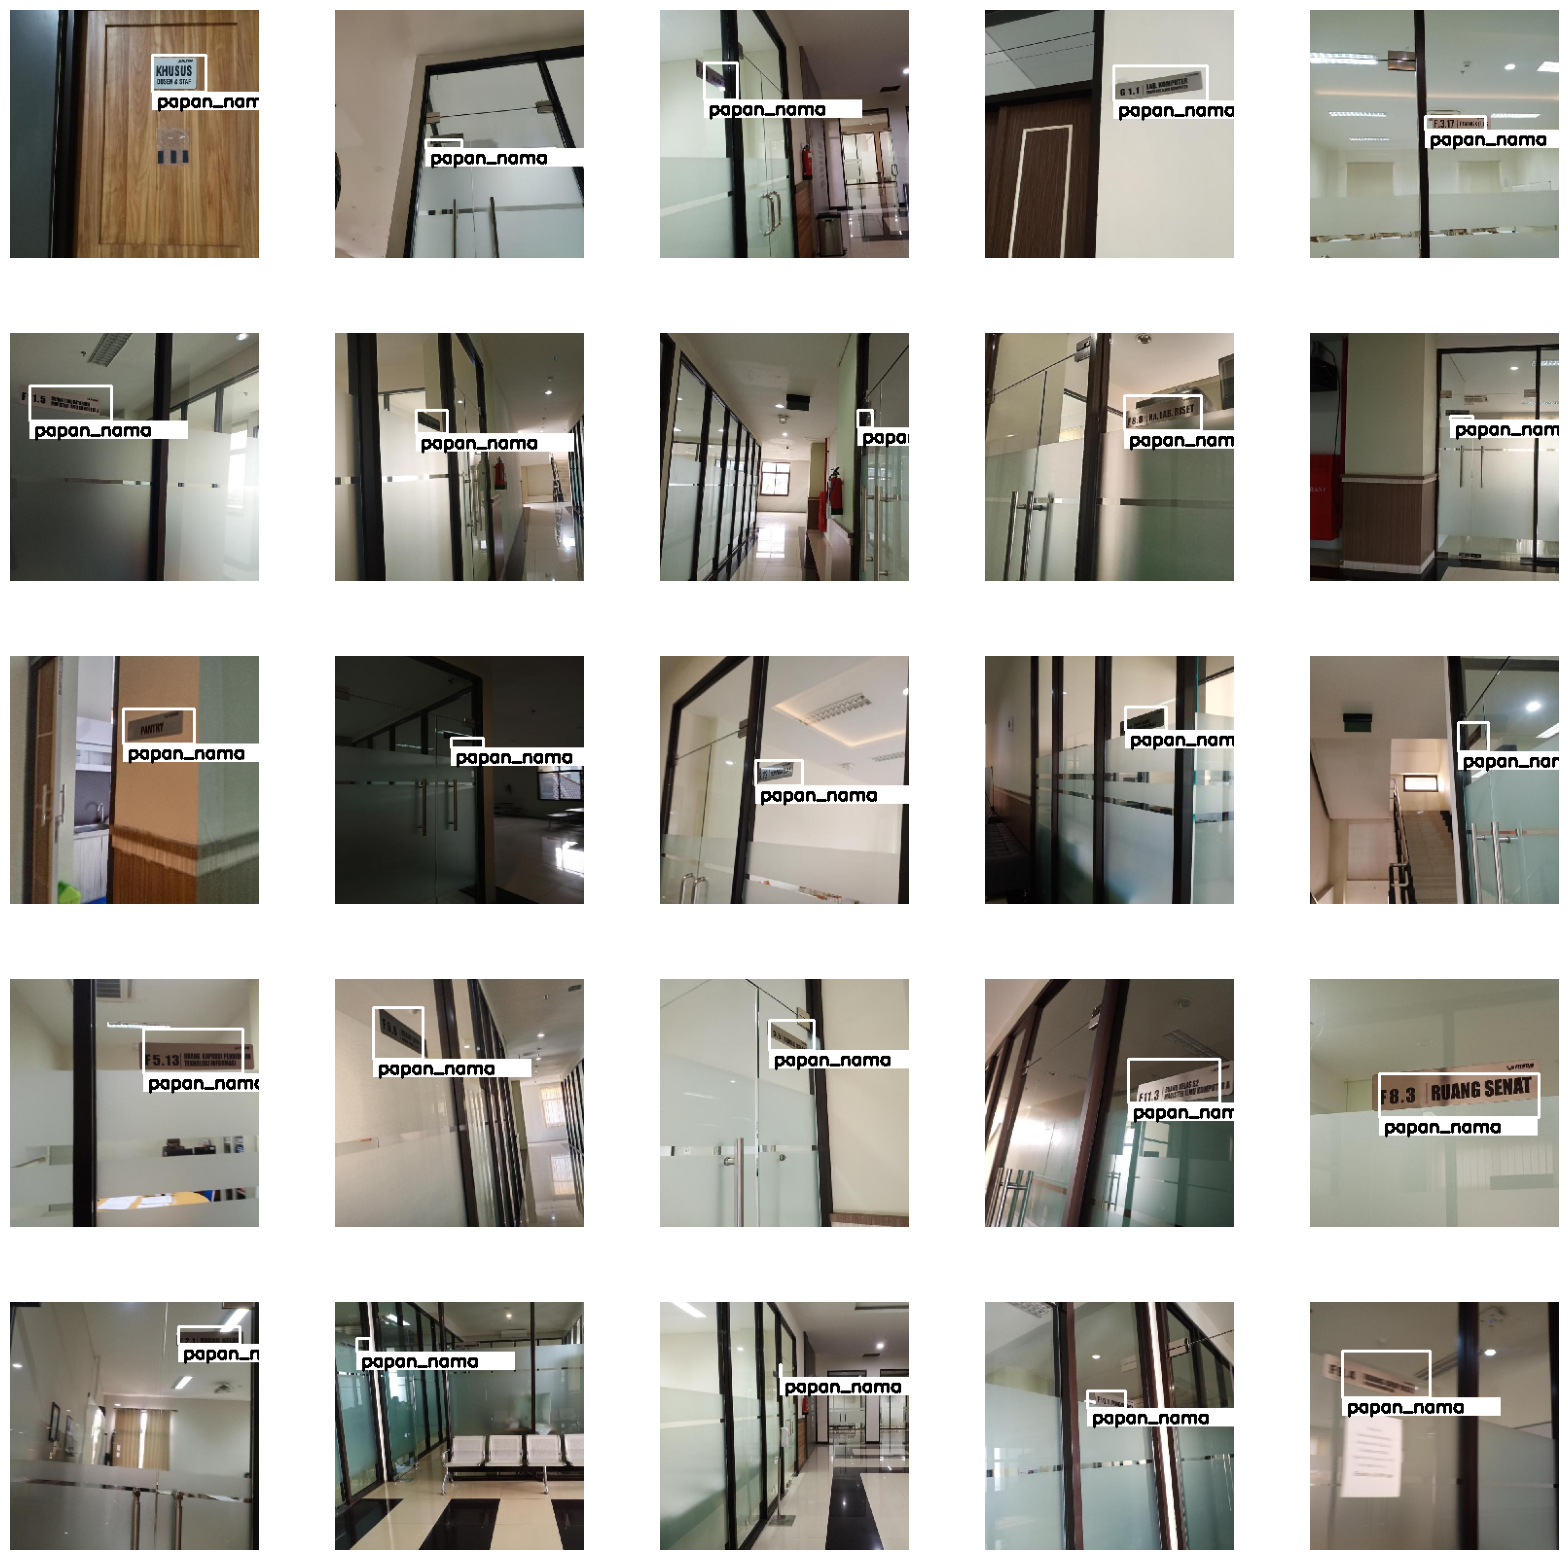

In [57]:
labels = ['papan_nama']
font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 0.8
color=(0,0,0)
thickness=2
img_size = 256

plt.figure(figsize = (20 , 20))

for ind, filename in enumerate(filenames):
    x = test[test['filename']== filename]
    label = labels[int(y_pred[x.index])]
    (width,height),b = cv2.getTextSize(label,font,fontScale,thickness)
    img = load_img(os.path.join('/content/file/train',filename),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.

    for record in y_bbox[x.index]:
        xmin = int(record[0]*img_size)
        ymin = int(record[1]*img_size)
        xmax = int(record[2]*img_size)
        ymax = int(record[3]*img_size)
        img = cv2.rectangle(img,(xmin,ymin),(xmax,ymax),(255,255,255),2)
        img = cv2.rectangle(img,(xmin,ymax),(xmin+width,ymax+height),(255,255,255),-1)
        img = cv2.putText(img,label,(xmin+5,ymax+15),font,fontScale-0.2,color,thickness,cv2.LINE_AA)

    plt.subplot(5 , 5, ind+1)
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
    plt.imshow(img)
    plt.axis("off")

Saving Gelap_4.jpg to Gelap_4.jpg
Saving Gelap_7.jpg to Gelap_7.jpg
Saving Terang_8.jpg to Terang_8.jpg
Saving Terang_10.jpg to Terang_10.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


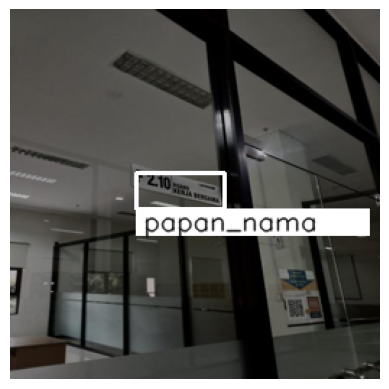

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


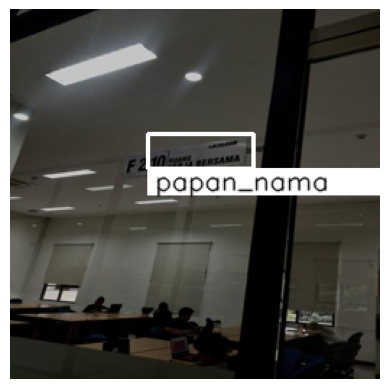

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


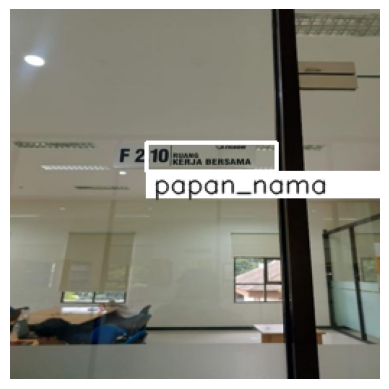

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


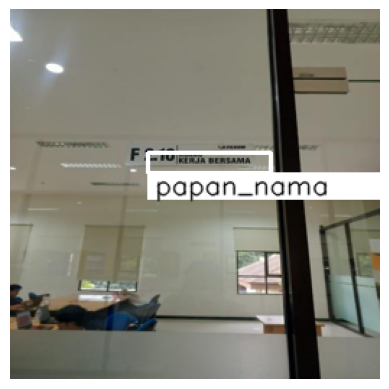

In [71]:
import matplotlib.pyplot as plt
from google.colab import files
import io
from PIL import Image
import numpy as np

uploaded = files.upload()

for fn in uploaded.keys():
    image = Image.open(io.BytesIO(uploaded[fn]))
    image = image.resize((256, 256))  # Resize to match model input
    image_array = np.array(image) / 255.0
    image_array = np.expand_dims(image_array, axis=0)

    # Predict using the model
    outputs = model.predict(image_array)
    y_bbox, y_pred = outputs

    # Assuming you want to display the bounding box if the prediction is above 0.5
    if y_pred[0][0] < 0.5:
        bbox = y_bbox[0]
        xmin = int(bbox[0] * 256)
        ymin = int(bbox[1] * 256)
        xmax = int(bbox[2] * 256)
        ymax = int(bbox[3] * 256)

        # Draw bounding box and label
        img_with_bbox = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
        img_with_bbox = cv2.rectangle(img_with_bbox, (xmin, ymin), (xmax, ymax), (255, 255, 255), 2)
        label = "papan_nama"
        font = cv2.FONT_HERSHEY_SIMPLEX
        fontScale = 0.8
        color = (0, 0, 0)
        thickness = 1
        (width, height), b = cv2.getTextSize(label, font, fontScale, thickness)
        img_with_bbox = cv2.rectangle(img_with_bbox, (xmin, ymax), (xmin + width, ymax + height), (255, 255, 255), -1)
        img_with_bbox = cv2.putText(img_with_bbox, label, (xmin + 5, ymax + 15), font, fontScale - 0.2, color, thickness, cv2.LINE_AA)

        # Display the image with bounding box
        plt.imshow(cv2.cvtColor(img_with_bbox, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.show()

    else:
        print("No object detected with confidence above 0.5.")
